<a href="https://colab.research.google.com/github/aaptecode/DS-Unit-4-Sprint-3-Neural-Networks/blob/master/DS43SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks Sprint Challenge

## 1) Define the following terms:

- Neuron
- Input Layer
- Hidden Layer
- Output Layer
- Activation
- Backpropagation

- **Neuron** - In a neural network, it's a cell of the network that stores a value and feeds into the next layer via an activation function.

- **Input Layer** - aka the visible layer,  it's the feature set converted into neurons which is fed into the neural network

- **Hidden Layer** - The black box layer of neurons that converts feature set neurons into a predicted target set. Deep learning involves more than one hidden layer. 

- **Output Layer** - The target vector converted into neurons where the number of neurons equals the number of unique target outcomes.

- **Activation** - A squish function used to map previous layers into subsequent layers.

- **Backpropagation** - A learning algorithm that uses gradient descent to adjust the weights from the oyutput to the input layer.


## 2) Create a perceptron class that can model the behavior of an AND gate. You can use the following table as your training data:

| x1 | x2 | x3 | y |
|----|----|----|---|
| 1  | 1  | 1  | 1 |
| 1  | 0  | 1  | 0 |
| 0  | 1  | 1  | 0 |
| 0  | 0  | 1  | 0 |

![AND Gate](https://cdn-images-1.medium.com/max/640/0*9QQhdtqhL6H2yMJ4.gif)

In [1]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 2.4MB/s 


In [0]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
np.random.seed(237)
style.use('seaborn-whitegrid')

**Input Layer and Correct Outputs**

In [0]:
##### Your Code Here #####

inputs = np.array([[1,1,1,1],
                   [1,1,0,1],
                   [1,0,1,1],
                   [1,0,0,1]]) # Bias vector added

correct_outputs = [[1],
                  [0],
                  [0],
                  [0]]

**Initial Weights**

In [4]:
weights = 2* np.random.random((4,1))-1

weights

array([[ 0.97561731],
       [-0.52256163],
       [-0.97208453],
       [ 0.63756872]])

**Activation Function**

In [0]:
def sigmoid(x):
    return (1 + np.exp(-x))**-1

def sigmoid_derivative(x):
    return sigmoid(x)* (1 - sigmoid(x))

**Neural Network**

In [6]:
%%time

for iteration in range(20000):
  
    # Weighted sum of inputs and weights
    weighted_sum = np.dot(inputs, weights)

    # Activate with sigmoid function
    activated_output = sigmoid(weighted_sum)

    # Calculate Error
    error = correct_outputs - activated_output

    # Calculate weight adjustments with sigmoid_derivative
    adjustments = error * sigmoid_derivative(activated_output)

    # Update weights
    weights += np.dot(inputs.T, adjustments)
  
print('optimized weights after training: ')
print(weights)
print()
print("Output After Training:")
print(activated_output)
print()

optimized weights after training: 
[[-10.37633475]
 [ 13.82972242]
 [ 13.82972242]
 [-10.71438334]]

Output After Training:
[[9.98598314e-01]
 [7.01950454e-04]
 [7.01950454e-04]
 [6.92600556e-10]]

CPU times: user 467 ms, sys: 0 ns, total: 467 ms
Wall time: 470 ms


In [7]:
activated_output.round(0).astype(int)

array([[1],
       [0],
       [0],
       [0]])

**The Output after Training is the same as the correct output.**

## 3) Implement a Neural Network Multilayer Perceptron class that uses backpropagation to update the network's weights. 
- Your network must have one hidden layer. 
- You do not have to update weights via gradient descent. You can use something like the derivative of the sigmoid function to update weights.
- Train your model on the Heart Disease dataset from UCI:

[Github Dataset](https://github.com/ryanleeallred/datasets/blob/master/heart.csv)

[Raw File on Github](https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv)


In [8]:
##### Your Code Here #####

url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv'

df = pd.read_csv(url)
print(df.shape, "\n")
df.head()

(303, 14) 



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [10]:
y = df.target
y = y.values.reshape(len(y), 1)
X = df.drop('target', axis='columns')
X = X.values

X.shape, y.shape

((303, 13), (303, 1))

In [11]:
# Scaling

mean = X.mean(axis=0)
X -= mean
std = X.std(axis=0)
X /= std

X

array([[ 0.9521966 ,  0.68100522,  1.97312292, ..., -2.27457861,
        -0.71442887, -2.14887271],
       [-1.91531289,  0.68100522,  1.00257707, ..., -2.27457861,
        -0.71442887, -0.51292188],
       [-1.47415758, -1.46841752,  0.03203122, ...,  0.97635214,
        -0.71442887, -0.51292188],
       ...,
       [ 1.50364073,  0.68100522, -0.93851463, ..., -0.64911323,
         1.24459328,  1.12302895],
       [ 0.29046364,  0.68100522, -0.93851463, ..., -0.64911323,
         0.26508221,  1.12302895],
       [ 0.29046364, -1.46841752,  0.03203122, ..., -0.64911323,
         0.26508221, -0.51292188]])

In [0]:
class Neural_Network(object):
    def __init__(self):        
        #Define Hyperparameters
        self.inputLayerSize = 13
        self.outputLayerSize = 1
        self.hiddenLayerSize = 26
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [0]:
from scipy import optimize
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [14]:
NN = Neural_Network()
T = trainer(NN)
T.train(X,y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in square


Optimization terminated successfully.
         Current function value: 13.000006
         Iterations: 126
         Function evaluations: 165
         Gradient evaluations: 165


In [15]:
print("Predicted Output: \n" + str(NN.forward(X))) 
print("Loss: \n" + str(np.mean(np.square(y - NN.forward(X))))) # mean sum squared loss

Predicted Output: 
[[1.00000000e+00]
 [9.99791025e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99722850e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99999836e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.98520319e-01]
 [1.00000000e+00]
 [9.99999228e-01]
 [9.99989191e-01]
 [9.99999958e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.26188793e-19]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.14684483e-26]
 [1.00000000e+00]
 [1.00000

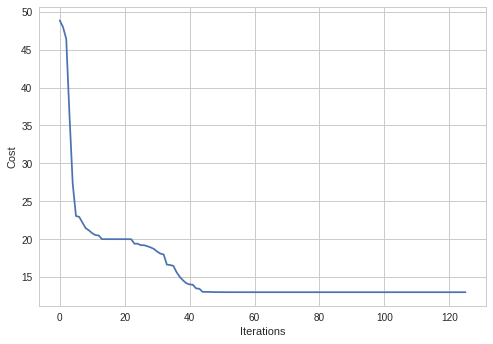

In [16]:
plt.plot(T.J)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show() 

## 4) Implement a Multilayer Perceptron architecture of your choosing using the Keras library. Train your model and report its baseline accuracy. Then hyperparameter tune at least two parameters and report your model's accuracy. 

- Use the Heart Disease Dataset (binary classification)
- Use an appropriate loss function for a binary classification task
- Use an appropriate activation function on the final layer of your network. 
- Train your model using verbose output for ease of grading.
- Use GridSearchCV to hyperparameter tune your model. (for at least two hyperparameters)
- When hyperparameter tuning, show you work by adding code cells for each new experiment. 
- Report the accuracy for each combination of hyperparameters as you test them so that we can easily see which resulted in the highest accuracy.
- You must hyperparameter tune at least 5 parameters in order to get a 3 on this section.

In [17]:
##### Your Code Here #####

url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv'

df = pd.read_csv(url)
print(df.shape, "\n")
df.head()

(303, 14) 



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [18]:
y = df.target
X = df.drop('target', axis='columns')

X.shape, y.shape

((303, 13), (303,))

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense
# from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
# from keras.wrappers.scikit_learn import KerasRegressor

import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler


Using TensorFlow backend.


### Baseline

In [20]:
%%time

# Function to create model, required for KerasClassifier
def create_model(activation='sigmoid', xtra_layers = 0):
    # create model
    print(f'Using activation {activation}')
    model = Sequential()
    model.add(Dense(12, input_dim=X.shape[1], activation=activation))
    for i in range(xtra_layers):
        model.add(Dense(12, activation=activation))
    model.add(Dense(1, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create pipeline
pipeline = make_pipeline(\
                         ce.BinaryEncoder(),
                         RobustScaler(), 
                         KerasClassifier(build_fn=create_model, verbose=1))

# Model validation.
param_grid = {
    'kerasclassifier__batch_size': [30],
    'kerasclassifier__activation': ['sigmoid'],
    'kerasclassifier__epochs': [1]
}

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv=5, 
                         scoring='accuracy', verbose=10)
gridsearch.fit(X, y)

# Interpret the results.

# Best cross validation score
print('\n\nCross Validation Score:', gridsearch.best_score_)

# Best parameters which resulted in the best score
print('Best Parameters:', gridsearch.best_params_)
print()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] kerasclassifier__activation=sigmoid, kerasclassifier__batch_size=30, kerasclassifier__epochs=1 
Using activation sigmoid
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/1
242/242 [==============================] - 0s 28us/step
[CV]  kerasclassifier__activation=sigmoid, kerasclassifier__batch_size=30, kerasclassifier__epochs=1, score=1.0, total=   1.4s
[CV] kerasclassifier__activation=sigmoid, kerasclassifier__batch_size=30, kerasclassifier__epochs=1 
Using activation sigmoid


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


Epoch 1/1
242/242 [==============================] - 0s 39us/step
[CV]  kerasclassifier__activation=sigmoid, kerasclassifier__batch_size=30, kerasclassifier__epochs=1, score=1.0, total=   0.7s
[CV] kerasclassifier__activation=sigmoid, kerasclassifier__batch_size=30, kerasclassifier__epochs=1 
Using activation sigmoid


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


Epoch 1/1
242/242 [==============================] - 0s 27us/step
[CV]  kerasclassifier__activation=sigmoid, kerasclassifier__batch_size=30, kerasclassifier__epochs=1, score=0.7049180327868853, total=   0.8s
[CV] kerasclassifier__activation=sigmoid, kerasclassifier__batch_size=30, kerasclassifier__epochs=1 
Using activation sigmoid


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s


Epoch 1/1
243/243 [==============================] - 0s 36us/step
[CV]  kerasclassifier__activation=sigmoid, kerasclassifier__batch_size=30, kerasclassifier__epochs=1, score=0.0, total=   1.0s
[CV] kerasclassifier__activation=sigmoid, kerasclassifier__batch_size=30, kerasclassifier__epochs=1 
Using activation sigmoid


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s


Epoch 1/1
243/243 [==============================] - 0s 48us/step
[CV]  kerasclassifier__activation=sigmoid, kerasclassifier__batch_size=30, kerasclassifier__epochs=1, score=0.0, total=   1.0s
Using activation sigmoid


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/1
303/303 [==============================] - 0s 2ms/step - loss: 7.2609 - acc: 0.5446


Cross Validation Score: 0.5445544554455446
Best Parameters: {'kerasclassifier__activation': 'sigmoid', 'kerasclassifier__batch_size': 30, 'kerasclassifier__epochs': 1}

CPU times: user 5.12 s, sys: 145 ms, total: 5.27 s
Wall time: 5.86 s


### Tuning Batch Size and Activation Model (1st and 2nd Hyperparameters)

In [21]:
%%time

# Function to create model, required for KerasClassifier
def create_model(activation='sigmoid', xtra_layers = 0):
    # create model
    print(f'Using activation {activation}')
    model = Sequential()
    model.add(Dense(12, input_dim=X.shape[1], activation=activation))
    for i in range(xtra_layers):
        model.add(Dense(12, activation=activation))
    model.add(Dense(1, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create pipeline
pipeline = make_pipeline(\
                         ce.BinaryEncoder(),
                         RobustScaler(), 
                         KerasClassifier(build_fn=create_model, verbose=1))

# Model validation.
param_grid = {
    'kerasclassifier__batch_size': [20, 30, 40, 50],
    'kerasclassifier__activation': ['tanh', 'relu', 'sigmoid'],
    'kerasclassifier__epochs': [25]
}

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv=5, 
                         scoring='accuracy', verbose=10)
gridsearch.fit(X, y)

# Interpret the results.

# Best cross validation score
print('\n\nCross Validation Score:', gridsearch.best_score_)

# Best parameters which resulted in the best score
print('Best Parameters:', gridsearch.best_params_)
print()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] kerasclassifier__activation=tanh, kerasclassifier__batch_size=20, kerasclassifier__epochs=25 
Using activation tanh


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
242/242 [==============================] - 1s 2ms/step - loss: 9.0911 - acc: 0.4298
Epoch 2/25
242/242 [==============================] - 0s 94us/step - loss: 9.0911 - acc: 0.4298
Epoch 3/25
242/242 [==============================] - 0s 124us/step - loss: 9.0911 - acc: 0.4298
Epoch 4/25
242/242 [==============================] - 0s 109us/step - loss: 9.0911 - acc: 0.4298
Epoch 5/25
242/242 [==============================] - 0s 101us/step - loss: 9.0911 - acc: 0.4298
Epoch 6/25
242/242 [==============================] - 0s 106us/step - loss: 9.0911 - acc: 0.4298
Epoch 7/25
242/242 [==============================] - 0s 91us/step - loss: 9.0911 - acc: 0.4298
Epoch 8/25
242/242 [==============================] - 0s 106us/step - loss: 9.0911 - acc: 0.4298
Epoch 9/25
242/242 [==============================] - 0s 117us/step - loss: 9.0911 - acc: 0.4298
Epoch 10/25
242/242 [==============================] - 0s 122us/step - loss: 9.0911 - acc: 0.4298
Epoch 11/25
242/242 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 1s 3ms/step - loss: 9.0911 - acc: 0.4298
Epoch 2/25
242/242 [==============================] - 0s 95us/step - loss: 9.0911 - acc: 0.4298
Epoch 3/25
242/242 [==============================] - 0s 101us/step - loss: 9.0911 - acc: 0.4298
Epoch 4/25
242/242 [==============================] - 0s 84us/step - loss: 9.0911 - acc: 0.4298
Epoch 5/25
242/242 [==============================] - 0s 86us/step - loss: 9.0911 - acc: 0.4298
Epoch 6/25
242/242 [==============================] - 0s 91us/step - loss: 9.0911 - acc: 0.4298
Epoch 7/25
242/242 [==============================] - 0s 94us/step - loss: 9.0911 - acc: 0.4298
Epoch 8/25
242/242 [==============================] - 0s 95us/step - loss: 9.0911 - acc: 0.4298
Epoch 9/25
242/242 [==============================] - 0s 93us/step - loss: 9.0911 - acc: 0.4298
Epoch 10/25
242/242 [==============================] - 0s 94us/step - loss: 9.0911 - acc: 0.4298
Epoch 11/25
242/242 [==================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 1s 3ms/step - loss: 7.9053 - acc: 0.5041
Epoch 2/25
242/242 [==============================] - 0s 95us/step - loss: 7.9053 - acc: 0.5041
Epoch 3/25
242/242 [==============================] - 0s 93us/step - loss: 7.9053 - acc: 0.5041
Epoch 4/25
242/242 [==============================] - 0s 85us/step - loss: 7.9053 - acc: 0.5041
Epoch 5/25
242/242 [==============================] - 0s 93us/step - loss: 7.9053 - acc: 0.5041
Epoch 6/25
242/242 [==============================] - 0s 94us/step - loss: 7.9053 - acc: 0.5041
Epoch 7/25
242/242 [==============================] - 0s 96us/step - loss: 7.9053 - acc: 0.5041
Epoch 8/25
242/242 [==============================] - 0s 95us/step - loss: 7.9053 - acc: 0.5041
Epoch 9/25
242/242 [==============================] - 0s 91us/step - loss: 7.9053 - acc: 0.5041
Epoch 10/25
242/242 [==============================] - 0s 92us/step - loss: 7.9053 - acc: 0.5041
Epoch 11/25
242/242 [===================

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s


Epoch 1/25
243/243 [==============================] - 1s 3ms/step - loss: 5.1173 - acc: 0.6790
Epoch 2/25
243/243 [==============================] - 0s 101us/step - loss: 5.1173 - acc: 0.6790
Epoch 3/25
243/243 [==============================] - 0s 92us/step - loss: 5.1173 - acc: 0.6790
Epoch 4/25
243/243 [==============================] - 0s 93us/step - loss: 5.1173 - acc: 0.6790
Epoch 5/25
243/243 [==============================] - 0s 97us/step - loss: 5.1173 - acc: 0.6790
Epoch 6/25
243/243 [==============================] - 0s 94us/step - loss: 5.1173 - acc: 0.6790
Epoch 7/25
243/243 [==============================] - 0s 102us/step - loss: 5.1173 - acc: 0.6790
Epoch 8/25
243/243 [==============================] - 0s 111us/step - loss: 5.1173 - acc: 0.6790
Epoch 9/25
243/243 [==============================] - 0s 119us/step - loss: 5.1173 - acc: 0.6790
Epoch 10/25
243/243 [==============================] - 0s 107us/step - loss: 5.1173 - acc: 0.6790
Epoch 11/25
243/243 [==============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.0s remaining:    0.0s


Epoch 1/25
243/243 [==============================] - 1s 3ms/step - loss: 5.1173 - acc: 0.6790
Epoch 2/25
243/243 [==============================] - 0s 85us/step - loss: 5.1173 - acc: 0.6790
Epoch 3/25
243/243 [==============================] - 0s 83us/step - loss: 5.1173 - acc: 0.6790
Epoch 4/25
243/243 [==============================] - 0s 87us/step - loss: 5.1173 - acc: 0.6790
Epoch 5/25
243/243 [==============================] - 0s 93us/step - loss: 5.1173 - acc: 0.6790
Epoch 6/25
243/243 [==============================] - 0s 89us/step - loss: 5.1173 - acc: 0.6790
Epoch 7/25
243/243 [==============================] - 0s 89us/step - loss: 5.1173 - acc: 0.6790
Epoch 8/25
243/243 [==============================] - 0s 89us/step - loss: 5.1173 - acc: 0.6790
Epoch 9/25
243/243 [==============================] - 0s 95us/step - loss: 5.1173 - acc: 0.6790
Epoch 10/25
243/243 [==============================] - 0s 96us/step - loss: 5.1173 - acc: 0.6790
Epoch 11/25
243/243 [===================

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.1s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 1s 3ms/step - loss: 9.0911 - acc: 0.4298
Epoch 2/25
242/242 [==============================] - 0s 73us/step - loss: 9.0911 - acc: 0.4298
Epoch 3/25
242/242 [==============================] - 0s 75us/step - loss: 9.0911 - acc: 0.4298
Epoch 4/25
242/242 [==============================] - 0s 78us/step - loss: 9.0911 - acc: 0.4298
Epoch 5/25
242/242 [==============================] - 0s 75us/step - loss: 9.0911 - acc: 0.4298
Epoch 6/25
242/242 [==============================] - 0s 80us/step - loss: 9.0911 - acc: 0.4298
Epoch 7/25
242/242 [==============================] - 0s 71us/step - loss: 9.0911 - acc: 0.4298
Epoch 8/25
242/242 [==============================] - 0s 82us/step - loss: 9.0911 - acc: 0.4298
Epoch 9/25
242/242 [==============================] - 0s 69us/step - loss: 9.0911 - acc: 0.4298
Epoch 10/25
242/242 [==============================] - 0s 84us/step - loss: 9.0911 - acc: 0.4298
Epoch 11/25
242/242 [===================

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.2s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 1s 4ms/step - loss: 9.0911 - acc: 0.4298
Epoch 2/25
242/242 [==============================] - 0s 73us/step - loss: 9.0911 - acc: 0.4298
Epoch 3/25
242/242 [==============================] - 0s 84us/step - loss: 9.0911 - acc: 0.4298
Epoch 4/25
242/242 [==============================] - 0s 75us/step - loss: 9.0911 - acc: 0.4298
Epoch 5/25
242/242 [==============================] - 0s 72us/step - loss: 9.0911 - acc: 0.4298
Epoch 6/25
242/242 [==============================] - 0s 77us/step - loss: 9.0911 - acc: 0.4298
Epoch 7/25
242/242 [==============================] - 0s 74us/step - loss: 9.0911 - acc: 0.4298
Epoch 8/25
242/242 [==============================] - 0s 83us/step - loss: 9.0911 - acc: 0.4298
Epoch 9/25
242/242 [==============================] - 0s 71us/step - loss: 9.0911 - acc: 0.4298
Epoch 10/25
242/242 [==============================] - 0s 97us/step - loss: 9.0911 - acc: 0.4298
Epoch 11/25
242/242 [===================

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.4s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 1s 4ms/step - loss: 7.9053 - acc: 0.5041
Epoch 2/25
242/242 [==============================] - 0s 86us/step - loss: 7.9053 - acc: 0.5041
Epoch 3/25
242/242 [==============================] - 0s 75us/step - loss: 7.9053 - acc: 0.5041
Epoch 4/25
242/242 [==============================] - 0s 82us/step - loss: 7.9053 - acc: 0.5041
Epoch 5/25
242/242 [==============================] - 0s 84us/step - loss: 7.9053 - acc: 0.5041
Epoch 6/25
242/242 [==============================] - 0s 78us/step - loss: 7.9053 - acc: 0.5041
Epoch 7/25
242/242 [==============================] - 0s 73us/step - loss: 7.9053 - acc: 0.5041
Epoch 8/25
242/242 [==============================] - 0s 75us/step - loss: 7.9053 - acc: 0.5041
Epoch 9/25
242/242 [==============================] - 0s 75us/step - loss: 7.9053 - acc: 0.5041
Epoch 10/25
242/242 [==============================] - 0s 97us/step - loss: 7.9053 - acc: 0.5041
Epoch 11/25
242/242 [===================

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.8s remaining:    0.0s


Epoch 1/25
243/243 [==============================] - 1s 4ms/step - loss: 5.1173 - acc: 0.6790
Epoch 2/25
243/243 [==============================] - 0s 74us/step - loss: 5.1173 - acc: 0.6790
Epoch 3/25
243/243 [==============================] - 0s 92us/step - loss: 5.1173 - acc: 0.6790
Epoch 4/25
243/243 [==============================] - 0s 87us/step - loss: 5.1173 - acc: 0.6790
Epoch 5/25
243/243 [==============================] - 0s 96us/step - loss: 5.1173 - acc: 0.6790
Epoch 6/25
243/243 [==============================] - 0s 80us/step - loss: 5.1173 - acc: 0.6790
Epoch 7/25
243/243 [==============================] - 0s 82us/step - loss: 5.1173 - acc: 0.6790
Epoch 8/25
243/243 [==============================] - 0s 74us/step - loss: 5.1173 - acc: 0.6790
Epoch 9/25
243/243 [==============================] - 0s 76us/step - loss: 5.1173 - acc: 0.6790
Epoch 10/25
243/243 [==============================] - 0s 86us/step - loss: 5.1173 - acc: 0.6790
Epoch 11/25
243/243 [===================

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   19.2s remaining:    0.0s


Epoch 1/25
243/243 [==============================] - 1s 4ms/step - loss: 5.1173 - acc: 0.6790
Epoch 2/25
243/243 [==============================] - 0s 82us/step - loss: 5.1173 - acc: 0.6790
Epoch 3/25
243/243 [==============================] - 0s 78us/step - loss: 5.1173 - acc: 0.6790
Epoch 4/25
243/243 [==============================] - 0s 77us/step - loss: 5.1173 - acc: 0.6790
Epoch 5/25
243/243 [==============================] - 0s 74us/step - loss: 5.1173 - acc: 0.6790
Epoch 6/25
243/243 [==============================] - 0s 80us/step - loss: 5.1173 - acc: 0.6790
Epoch 7/25
243/243 [==============================] - 0s 86us/step - loss: 5.1173 - acc: 0.6790
Epoch 8/25
243/243 [==============================] - 0s 73us/step - loss: 5.1173 - acc: 0.6790
Epoch 9/25
243/243 [==============================] - 0s 95us/step - loss: 5.1173 - acc: 0.6790
Epoch 10/25
243/243 [==============================] - 0s 77us/step - loss: 5.1173 - acc: 0.6790
Epoch 11/25
243/243 [===================

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/25
303/303 [==============================] - 4s 14ms/step - loss: 7.2609 - acc: 0.5446
Epoch 2/25
303/303 [==============================] - 0s 154us/step - loss: 7.2609 - acc: 0.5446
Epoch 3/25
303/303 [==============================] - 0s 148us/step - loss: 7.2609 - acc: 0.5446
Epoch 4/25
303/303 [==============================] - 0s 143us/step - loss: 7.2609 - acc: 0.5446
Epoch 5/25
303/303 [==============================] - 0s 144us/step - loss: 7.2609 - acc: 0.5446
Epoch 6/25
303/303 [==============================] - 0s 154us/step - loss: 7.2609 - acc: 0.5446
Epoch 7/25
303/303 [==============================] - 0s 154us/step - loss: 7.2609 - acc: 0.5446
Epoch 8/25
303/303 [==============================] - 0s 155us/step - loss: 7.2609 - acc: 0.5446
Epoch 9/25
303/303 [==============================] - 0s 166us/step - loss: 7.2609 - acc: 0.5446
Epoch 10/25
303/303 [==============================] - 0s 162us/step - loss: 7.2609 - acc: 0.5446
Epoch 11/25
303/303 [=========

### Hypertuning number of extra hidden layers and the number of cells per layer (3rd and 4th Hyperparameters)

In [22]:
%%time

# Function to create model, required for KerasClassifier
def create_model(activation='sigmoid', xtra_layers = 0, cell_no = 12):
    # create model
    print(f'Using activation {activation}')
    model = Sequential()
    model.add(Dense(cell_no, input_dim=X.shape[1], activation=activation))
    for i in range(xtra_layers):
        model.add(Dense(cell_no, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create pipeline
pipeline = make_pipeline(\
                         ce.BinaryEncoder(),
                         RobustScaler(), 
                         KerasClassifier(build_fn=create_model, verbose=1))

# Model validation.
param_grid = {
    'kerasclassifier__batch_size': [20],
    'kerasclassifier__activation': ['tanh'],
    'kerasclassifier__xtra_layers': [0, 1, 2, 3],
    'kerasclassifier__cell_no': [12, 18, 24, 30],
    'kerasclassifier__epochs': [25]
}

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv=5, 
                         scoring='accuracy', verbose=10)
gridsearch.fit(X, y)

# Interpret the results.

# Best cross validation score
print('Cross Validation Score:', gridsearch.best_score_)

# Best parameters which resulted in the best score
print('Best Parameters:', gridsearch.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] kerasclassifier__activation=tanh, kerasclassifier__batch_size=20, kerasclassifier__cell_no=12, kerasclassifier__epochs=25, kerasclassifier__xtra_layers=0 
Using activation tanh


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
242/242 [==============================] - 4s 19ms/step - loss: 0.6813 - acc: 0.5950
Epoch 2/25
242/242 [==============================] - 0s 157us/step - loss: 0.6417 - acc: 0.6529
Epoch 3/25
242/242 [==============================] - 0s 158us/step - loss: 0.6095 - acc: 0.6901
Epoch 4/25
242/242 [==============================] - 0s 165us/step - loss: 0.5815 - acc: 0.7273
Epoch 5/25
242/242 [==============================] - 0s 160us/step - loss: 0.5561 - acc: 0.7314
Epoch 6/25
242/242 [==============================] - 0s 174us/step - loss: 0.5354 - acc: 0.7314
Epoch 7/25
242/242 [==============================] - 0s 223us/step - loss: 0.5161 - acc: 0.7479
Epoch 8/25
242/242 [==============================] - 0s 171us/step - loss: 0.4996 - acc: 0.7562
Epoch 9/25
242/242 [==============================] - 0s 163us/step - loss: 0.4860 - acc: 0.7603
Epoch 10/25
242/242 [==============================] - 0s 149us/step - loss: 0.4748 - acc: 0.7727
Epoch 11/25
242/242 [=========

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 4s 17ms/step - loss: 0.6166 - acc: 0.6694
Epoch 2/25
242/242 [==============================] - 0s 159us/step - loss: 0.5891 - acc: 0.6818
Epoch 3/25
242/242 [==============================] - 0s 167us/step - loss: 0.5676 - acc: 0.6942
Epoch 4/25
242/242 [==============================] - 0s 173us/step - loss: 0.5486 - acc: 0.7314
Epoch 5/25
242/242 [==============================] - 0s 164us/step - loss: 0.5306 - acc: 0.7603
Epoch 6/25
242/242 [==============================] - 0s 162us/step - loss: 0.5141 - acc: 0.7810
Epoch 7/25
242/242 [==============================] - 0s 166us/step - loss: 0.4999 - acc: 0.7810
Epoch 8/25
242/242 [==============================] - 0s 174us/step - loss: 0.4878 - acc: 0.7851
Epoch 9/25
242/242 [==============================] - 0s 164us/step - loss: 0.4766 - acc: 0.7851
Epoch 10/25
242/242 [==============================] - 0s 147us/step - loss: 0.4646 - acc: 0.8017
Epoch 11/25
242/242 [=========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 4s 18ms/step - loss: 0.7861 - acc: 0.3430
Epoch 2/25
242/242 [==============================] - 0s 172us/step - loss: 0.7476 - acc: 0.4215
Epoch 3/25
242/242 [==============================] - 0s 159us/step - loss: 0.7122 - acc: 0.5041
Epoch 4/25
242/242 [==============================] - 0s 156us/step - loss: 0.6809 - acc: 0.5909
Epoch 5/25
242/242 [==============================] - 0s 178us/step - loss: 0.6532 - acc: 0.6281
Epoch 6/25
242/242 [==============================] - 0s 158us/step - loss: 0.6280 - acc: 0.6612
Epoch 7/25
242/242 [==============================] - 0s 168us/step - loss: 0.6060 - acc: 0.6694
Epoch 8/25
242/242 [==============================] - 0s 166us/step - loss: 0.5861 - acc: 0.6983
Epoch 9/25
242/242 [==============================] - 0s 159us/step - loss: 0.5686 - acc: 0.7190
Epoch 10/25
242/242 [==============================] - 0s 171us/step - loss: 0.5523 - acc: 0.7438
Epoch 11/25
242/242 [=========

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.3s remaining:    0.0s


Epoch 1/25
243/243 [==============================] - 4s 18ms/step - loss: 0.8022 - acc: 0.3580
Epoch 2/25
243/243 [==============================] - 0s 158us/step - loss: 0.7601 - acc: 0.4074
Epoch 3/25
243/243 [==============================] - 0s 162us/step - loss: 0.7221 - acc: 0.4650
Epoch 4/25
243/243 [==============================] - 0s 189us/step - loss: 0.6862 - acc: 0.5350
Epoch 5/25
243/243 [==============================] - 0s 196us/step - loss: 0.6549 - acc: 0.6255
Epoch 6/25
243/243 [==============================] - 0s 169us/step - loss: 0.6255 - acc: 0.6914
Epoch 7/25
243/243 [==============================] - 0s 167us/step - loss: 0.5998 - acc: 0.7243
Epoch 8/25
243/243 [==============================] - 0s 163us/step - loss: 0.5752 - acc: 0.7531
Epoch 9/25
243/243 [==============================] - 0s 178us/step - loss: 0.5535 - acc: 0.7984
Epoch 10/25
243/243 [==============================] - 0s 166us/step - loss: 0.5329 - acc: 0.8066
Epoch 11/25
243/243 [=========

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   30.9s remaining:    0.0s


Epoch 1/25
243/243 [==============================] - 4s 18ms/step - loss: 0.8831 - acc: 0.3210
Epoch 2/25
243/243 [==============================] - 0s 166us/step - loss: 0.8341 - acc: 0.3539
Epoch 3/25
243/243 [==============================] - 0s 177us/step - loss: 0.7921 - acc: 0.3868
Epoch 4/25
243/243 [==============================] - 0s 160us/step - loss: 0.7521 - acc: 0.4486
Epoch 5/25
243/243 [==============================] - 0s 184us/step - loss: 0.7177 - acc: 0.5350
Epoch 6/25
243/243 [==============================] - 0s 169us/step - loss: 0.6843 - acc: 0.6091
Epoch 7/25
243/243 [==============================] - 0s 165us/step - loss: 0.6540 - acc: 0.6420
Epoch 8/25
243/243 [==============================] - 0s 205us/step - loss: 0.6276 - acc: 0.6790
Epoch 9/25
243/243 [==============================] - 0s 156us/step - loss: 0.6025 - acc: 0.7284
Epoch 10/25
243/243 [==============================] - 0s 160us/step - loss: 0.5804 - acc: 0.7531
Epoch 11/25
243/243 [=========

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.6s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 5s 19ms/step - loss: 0.5884 - acc: 0.7231
Epoch 2/25
242/242 [==============================] - 0s 175us/step - loss: 0.5438 - acc: 0.7562
Epoch 3/25
242/242 [==============================] - 0s 182us/step - loss: 0.5127 - acc: 0.7810
Epoch 4/25
242/242 [==============================] - 0s 178us/step - loss: 0.4864 - acc: 0.7934
Epoch 5/25
242/242 [==============================] - 0s 172us/step - loss: 0.4672 - acc: 0.8099
Epoch 6/25
242/242 [==============================] - 0s 177us/step - loss: 0.4511 - acc: 0.8099
Epoch 7/25
242/242 [==============================] - 0s 177us/step - loss: 0.4383 - acc: 0.8058
Epoch 8/25
242/242 [==============================] - 0s 194us/step - loss: 0.4278 - acc: 0.8099
Epoch 9/25
242/242 [==============================] - 0s 185us/step - loss: 0.4184 - acc: 0.8099
Epoch 10/25
242/242 [==============================] - 0s 186us/step - loss: 0.4103 - acc: 0.8140
Epoch 11/25
242/242 [=========

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   46.7s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 5s 19ms/step - loss: 0.7850 - acc: 0.3182
Epoch 2/25
242/242 [==============================] - 0s 176us/step - loss: 0.7104 - acc: 0.4959
Epoch 3/25
242/242 [==============================] - 0s 184us/step - loss: 0.6530 - acc: 0.6322
Epoch 4/25
242/242 [==============================] - 0s 174us/step - loss: 0.6063 - acc: 0.7025
Epoch 5/25
242/242 [==============================] - 0s 196us/step - loss: 0.5675 - acc: 0.7397
Epoch 6/25
242/242 [==============================] - 0s 191us/step - loss: 0.5381 - acc: 0.7355
Epoch 7/25
242/242 [==============================] - 0s 181us/step - loss: 0.5154 - acc: 0.7438
Epoch 8/25
242/242 [==============================] - 0s 211us/step - loss: 0.4944 - acc: 0.7645
Epoch 9/25
242/242 [==============================] - 0s 183us/step - loss: 0.4765 - acc: 0.7686
Epoch 10/25
242/242 [==============================] - 0s 183us/step - loss: 0.4589 - acc: 0.7893
Epoch 11/25
242/242 [=========

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   54.9s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 5s 19ms/step - loss: 0.7291 - acc: 0.5083
Epoch 2/25
242/242 [==============================] - 0s 215us/step - loss: 0.6809 - acc: 0.5785
Epoch 3/25
242/242 [==============================] - 0s 183us/step - loss: 0.6398 - acc: 0.6405
Epoch 4/25
242/242 [==============================] - 0s 179us/step - loss: 0.6057 - acc: 0.6818
Epoch 5/25
242/242 [==============================] - 0s 182us/step - loss: 0.5764 - acc: 0.7314
Epoch 6/25
242/242 [==============================] - 0s 207us/step - loss: 0.5483 - acc: 0.7645
Epoch 7/25
242/242 [==============================] - 0s 186us/step - loss: 0.5235 - acc: 0.7851
Epoch 8/25
242/242 [==============================] - 0s 180us/step - loss: 0.5025 - acc: 0.7851
Epoch 9/25
242/242 [==============================] - 0s 188us/step - loss: 0.4821 - acc: 0.8058
Epoch 10/25
242/242 [==============================] - 0s 186us/step - loss: 0.4626 - acc: 0.8099
Epoch 11/25
242/242 [=========

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s


Epoch 1/25
243/243 [==============================] - 5s 20ms/step - loss: 0.8037 - acc: 0.3868
Epoch 2/25
243/243 [==============================] - 0s 172us/step - loss: 0.7491 - acc: 0.4403
Epoch 3/25
243/243 [==============================] - 0s 175us/step - loss: 0.7067 - acc: 0.4938
Epoch 4/25
243/243 [==============================] - 0s 198us/step - loss: 0.6738 - acc: 0.5679
Epoch 5/25
243/243 [==============================] - 0s 205us/step - loss: 0.6462 - acc: 0.6420
Epoch 6/25
243/243 [==============================] - 0s 243us/step - loss: 0.6245 - acc: 0.6790
Epoch 7/25
243/243 [==============================] - 0s 178us/step - loss: 0.6037 - acc: 0.6996
Epoch 8/25
243/243 [==============================] - 0s 196us/step - loss: 0.5835 - acc: 0.7366
Epoch 9/25
243/243 [==============================] - 0s 181us/step - loss: 0.5638 - acc: 0.7654
Epoch 10/25
243/243 [==============================] - 0s 198us/step - loss: 0.5436 - acc: 0.7819
Epoch 11/25
243/243 [=========

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


Epoch 1/25
243/243 [==============================] - 5s 20ms/step - loss: 0.6831 - acc: 0.5556
Epoch 2/25
243/243 [==============================] - 0s 185us/step - loss: 0.6480 - acc: 0.6091
Epoch 3/25
243/243 [==============================] - 0s 176us/step - loss: 0.6180 - acc: 0.6626
Epoch 4/25
243/243 [==============================] - 0s 186us/step - loss: 0.5912 - acc: 0.7325
Epoch 5/25
243/243 [==============================] - 0s 200us/step - loss: 0.5635 - acc: 0.7654
Epoch 6/25
243/243 [==============================] - 0s 186us/step - loss: 0.5385 - acc: 0.7942
Epoch 7/25
243/243 [==============================] - 0s 192us/step - loss: 0.5152 - acc: 0.8025
Epoch 8/25
243/243 [==============================] - 0s 195us/step - loss: 0.4942 - acc: 0.8107
Epoch 9/25
243/243 [==============================] - 0s 208us/step - loss: 0.4749 - acc: 0.8148
Epoch 10/25
243/243 [==============================] - 0s 231us/step - loss: 0.4566 - acc: 0.8189
Epoch 11/25
243/243 [=========

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 18.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/25
303/303 [==============================] - 12s 39ms/step - loss: 0.6157 - acc: 0.6832
Epoch 2/25
303/303 [==============================] - 0s 388us/step - loss: 0.5023 - acc: 0.7822
Epoch 3/25
303/303 [==============================] - 0s 483us/step - loss: 0.4411 - acc: 0.8020
Epoch 4/25
303/303 [==============================] - 0s 478us/step - loss: 0.4112 - acc: 0.8251
Epoch 5/25
303/303 [==============================] - 0s 469us/step - loss: 0.3906 - acc: 0.8350
Epoch 6/25
303/303 [==============================] - 0s 452us/step - loss: 0.3782 - acc: 0.8449
Epoch 7/25
303/303 [==============================] - 0s 488us/step - loss: 0.3662 - acc: 0.8515
Epoch 8/25
303/303 [==============================] - 0s 453us/step - loss: 0.3596 - acc: 0.8581
Epoch 9/25
303/303 [==============================] - 0s 443us/step - loss: 0.3531 - acc: 0.8614
Epoch 10/25
303/303 [==============================] - 0s 436us/step - loss: 0.3519 - acc: 0.8548
Epoch 11/25
303/303 [========

### Epoch (5th Parameter Hypertuned)

In [23]:
%%time

# Function to create model, required for KerasClassifier
def create_model(activation='sigmoid', xtra_layers = 2, cell_no = 18):
    # create model
    print(f'Using activation {activation}')
    model = Sequential()
    model.add(Dense(cell_no, input_dim=X.shape[1], activation=activation))
    for i in range(xtra_layers):
        model.add(Dense(cell_no, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create pipeline
pipeline = make_pipeline(\
                         ce.BinaryEncoder(),
                         RobustScaler(), 
                         KerasClassifier(build_fn=create_model, verbose=1))

# Model validation.
param_grid = {
    'kerasclassifier__batch_size': [20],
    'kerasclassifier__activation': ['tanh'],
    'kerasclassifier__xtra_layers': [2],
    'kerasclassifier__cell_no': [24],
    'kerasclassifier__epochs': [25, 50, 75, 100]
}

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv=5, 
                         scoring='accuracy', verbose=10)
gridsearch.fit(X, y)

# Interpret the results.

# Best cross validation score
print('Cross Validation Score:', gridsearch.best_score_)

# Best parameters which resulted in the best score
print('Best Parameters:', gridsearch.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] kerasclassifier__activation=tanh, kerasclassifier__batch_size=20, kerasclassifier__cell_no=24, kerasclassifier__epochs=25, kerasclassifier__xtra_layers=2 
Using activation tanh


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
242/242 [==============================] - 12s 50ms/step - loss: 0.7461 - acc: 0.4463
Epoch 2/25
242/242 [==============================] - 0s 471us/step - loss: 0.6110 - acc: 0.6612
Epoch 3/25
242/242 [==============================] - 0s 501us/step - loss: 0.5400 - acc: 0.7273
Epoch 4/25
242/242 [==============================] - 0s 481us/step - loss: 0.4819 - acc: 0.7810
Epoch 5/25
242/242 [==============================] - 0s 497us/step - loss: 0.4399 - acc: 0.7851
Epoch 6/25
242/242 [==============================] - 0s 480us/step - loss: 0.4154 - acc: 0.8058
Epoch 7/25
242/242 [==============================] - 0s 506us/step - loss: 0.3918 - acc: 0.8264
Epoch 8/25
242/242 [==============================] - 0s 507us/step - loss: 0.3795 - acc: 0.8264
Epoch 9/25
242/242 [==============================] - 0s 461us/step - loss: 0.3690 - acc: 0.8471
Epoch 10/25
242/242 [==============================] - 0s 511us/step - loss: 0.3618 - acc: 0.8512
Epoch 11/25
242/242 [========

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 12s 50ms/step - loss: 0.6175 - acc: 0.6983
Epoch 2/25
242/242 [==============================] - 0s 645us/step - loss: 0.4878 - acc: 0.8099
Epoch 3/25
242/242 [==============================] - 0s 643us/step - loss: 0.4174 - acc: 0.8140
Epoch 4/25
242/242 [==============================] - 0s 662us/step - loss: 0.3847 - acc: 0.8223
Epoch 5/25
242/242 [==============================] - 0s 651us/step - loss: 0.3642 - acc: 0.8388
Epoch 6/25
242/242 [==============================] - 0s 615us/step - loss: 0.3509 - acc: 0.8512
Epoch 7/25
242/242 [==============================] - 0s 635us/step - loss: 0.3440 - acc: 0.8512
Epoch 8/25
242/242 [==============================] - 0s 652us/step - loss: 0.3363 - acc: 0.8554
Epoch 9/25
242/242 [==============================] - 0s 707us/step - loss: 0.3360 - acc: 0.8512
Epoch 10/25
242/242 [==============================] - 0s 518us/step - loss: 0.3298 - acc: 0.8636
Epoch 11/25
242/242 [========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.4s remaining:    0.0s


Epoch 1/25
242/242 [==============================] - 12s 52ms/step - loss: 0.6199 - acc: 0.6983
Epoch 2/25
242/242 [==============================] - 0s 493us/step - loss: 0.5146 - acc: 0.8347
Epoch 3/25
242/242 [==============================] - 0s 473us/step - loss: 0.4459 - acc: 0.8099
Epoch 4/25
242/242 [==============================] - 0s 495us/step - loss: 0.4085 - acc: 0.8223
Epoch 5/25
242/242 [==============================] - 0s 490us/step - loss: 0.3784 - acc: 0.8388
Epoch 6/25
242/242 [==============================] - 0s 458us/step - loss: 0.3634 - acc: 0.8554
Epoch 7/25
242/242 [==============================] - 0s 477us/step - loss: 0.3571 - acc: 0.8471
Epoch 8/25
242/242 [==============================] - 0s 469us/step - loss: 0.3501 - acc: 0.8471
Epoch 9/25
242/242 [==============================] - 0s 465us/step - loss: 0.3441 - acc: 0.8554
Epoch 10/25
242/242 [==============================] - 0s 451us/step - loss: 0.3402 - acc: 0.8471
Epoch 11/25
242/242 [========

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


Epoch 1/25
243/243 [==============================] - 13s 52ms/step - loss: 0.6416 - acc: 0.7078
Epoch 2/25
243/243 [==============================] - 0s 497us/step - loss: 0.5596 - acc: 0.7778
Epoch 3/25
243/243 [==============================] - 0s 503us/step - loss: 0.5069 - acc: 0.7572
Epoch 4/25
243/243 [==============================] - 0s 575us/step - loss: 0.4705 - acc: 0.7901
Epoch 5/25
243/243 [==============================] - 0s 483us/step - loss: 0.4439 - acc: 0.7901
Epoch 6/25
243/243 [==============================] - 0s 503us/step - loss: 0.4210 - acc: 0.7984
Epoch 7/25
243/243 [==============================] - 0s 463us/step - loss: 0.4025 - acc: 0.8272
Epoch 8/25
243/243 [==============================] - 0s 445us/step - loss: 0.3874 - acc: 0.8436
Epoch 9/25
243/243 [==============================] - 0s 438us/step - loss: 0.3757 - acc: 0.8436
Epoch 10/25
243/243 [==============================] - 0s 458us/step - loss: 0.3668 - acc: 0.8436
Epoch 11/25
243/243 [========

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


Epoch 1/25
243/243 [==============================] - 13s 52ms/step - loss: 0.6566 - acc: 0.6049
Epoch 2/25
243/243 [==============================] - 0s 550us/step - loss: 0.5670 - acc: 0.6872
Epoch 3/25
243/243 [==============================] - 0s 590us/step - loss: 0.5120 - acc: 0.7449
Epoch 4/25
243/243 [==============================] - 0s 510us/step - loss: 0.4575 - acc: 0.7984
Epoch 5/25
243/243 [==============================] - 0s 540us/step - loss: 0.4182 - acc: 0.8395
Epoch 6/25
243/243 [==============================] - 0s 499us/step - loss: 0.3894 - acc: 0.8560
Epoch 7/25
243/243 [==============================] - 0s 548us/step - loss: 0.3623 - acc: 0.8519
Epoch 8/25
243/243 [==============================] - 0s 490us/step - loss: 0.3497 - acc: 0.8642
Epoch 9/25
243/243 [==============================] - 0s 529us/step - loss: 0.3334 - acc: 0.8683
Epoch 10/25
243/243 [==============================] - 0s 521us/step - loss: 0.3239 - acc: 0.8807
Epoch 11/25
243/243 [========

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s


Epoch 1/50
242/242 [==============================] - 13s 53ms/step - loss: 0.5641 - acc: 0.7314
Epoch 2/50
242/242 [==============================] - 0s 559us/step - loss: 0.4948 - acc: 0.7727
Epoch 3/50
242/242 [==============================] - 0s 561us/step - loss: 0.4582 - acc: 0.7810
Epoch 4/50
242/242 [==============================] - 0s 553us/step - loss: 0.4327 - acc: 0.8058
Epoch 5/50
242/242 [==============================] - 0s 592us/step - loss: 0.4127 - acc: 0.8140
Epoch 6/50
242/242 [==============================] - 0s 591us/step - loss: 0.3988 - acc: 0.8223
Epoch 7/50
242/242 [==============================] - 0s 517us/step - loss: 0.3876 - acc: 0.8182
Epoch 8/50
242/242 [==============================] - 0s 522us/step - loss: 0.3766 - acc: 0.8223
Epoch 9/50
242/242 [==============================] - 0s 495us/step - loss: 0.3688 - acc: 0.8306
Epoch 10/50
242/242 [==============================] - 0s 519us/step - loss: 0.3612 - acc: 0.8306
Epoch 11/50
242/242 [========

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.2min remaining:    0.0s


Epoch 1/50
242/242 [==============================] - 13s 53ms/step - loss: 0.5991 - acc: 0.7190
Epoch 2/50
242/242 [==============================] - 0s 498us/step - loss: 0.4702 - acc: 0.8306
Epoch 3/50
242/242 [==============================] - 0s 498us/step - loss: 0.4052 - acc: 0.8430
Epoch 4/50
242/242 [==============================] - 0s 472us/step - loss: 0.3705 - acc: 0.8388
Epoch 5/50
242/242 [==============================] - 0s 484us/step - loss: 0.3541 - acc: 0.8471
Epoch 6/50
242/242 [==============================] - 0s 545us/step - loss: 0.3443 - acc: 0.8554
Epoch 7/50
242/242 [==============================] - 0s 503us/step - loss: 0.3382 - acc: 0.8512
Epoch 8/50
242/242 [==============================] - 0s 553us/step - loss: 0.3350 - acc: 0.8512
Epoch 9/50
242/242 [==============================] - 0s 542us/step - loss: 0.3323 - acc: 0.8554
Epoch 10/50
242/242 [==============================] - 0s 553us/step - loss: 0.3309 - acc: 0.8595
Epoch 11/50
242/242 [========

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.6min remaining:    0.0s


Epoch 1/50
242/242 [==============================] - 13s 56ms/step - loss: 0.7354 - acc: 0.4876
Epoch 2/50
242/242 [==============================] - 0s 377us/step - loss: 0.6173 - acc: 0.7025
Epoch 3/50
242/242 [==============================] - 0s 515us/step - loss: 0.5436 - acc: 0.7603
Epoch 4/50
242/242 [==============================] - 0s 399us/step - loss: 0.4906 - acc: 0.7645
Epoch 5/50
242/242 [==============================] - 0s 563us/step - loss: 0.4516 - acc: 0.7727
Epoch 6/50
242/242 [==============================] - 0s 472us/step - loss: 0.4189 - acc: 0.8058
Epoch 7/50
242/242 [==============================] - 0s 435us/step - loss: 0.3992 - acc: 0.8140
Epoch 8/50
242/242 [==============================] - 0s 447us/step - loss: 0.3818 - acc: 0.8182
Epoch 9/50
242/242 [==============================] - 0s 605us/step - loss: 0.3667 - acc: 0.8182
Epoch 10/50
242/242 [==============================] - 0s 582us/step - loss: 0.3594 - acc: 0.8306
Epoch 11/50
242/242 [========

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.1min remaining:    0.0s


Epoch 1/50
243/243 [==============================] - 13s 54ms/step - loss: 0.6917 - acc: 0.5432
Epoch 2/50
243/243 [==============================] - 0s 571us/step - loss: 0.6177 - acc: 0.6749
Epoch 3/50
243/243 [==============================] - 0s 581us/step - loss: 0.5637 - acc: 0.7531
Epoch 4/50
243/243 [==============================] - 0s 559us/step - loss: 0.5208 - acc: 0.7860
Epoch 5/50
243/243 [==============================] - 0s 574us/step - loss: 0.4865 - acc: 0.7819
Epoch 6/50
243/243 [==============================] - 0s 549us/step - loss: 0.4542 - acc: 0.8313
Epoch 7/50
243/243 [==============================] - 0s 547us/step - loss: 0.4308 - acc: 0.8354
Epoch 8/50
243/243 [==============================] - 0s 566us/step - loss: 0.4091 - acc: 0.8436
Epoch 9/50
243/243 [==============================] - 0s 558us/step - loss: 0.3878 - acc: 0.8436
Epoch 10/50
243/243 [==============================] - 0s 515us/step - loss: 0.3776 - acc: 0.8560
Epoch 11/50
243/243 [========

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.5min remaining:    0.0s


Epoch 1/50
243/243 [==============================] - 14s 56ms/step - loss: 0.6791 - acc: 0.6008
Epoch 2/50
243/243 [==============================] - 0s 314us/step - loss: 0.5816 - acc: 0.7737
Epoch 3/50
243/243 [==============================] - 0s 372us/step - loss: 0.5129 - acc: 0.8354
Epoch 4/50
243/243 [==============================] - 0s 541us/step - loss: 0.4580 - acc: 0.8354
Epoch 5/50
243/243 [==============================] - 0s 574us/step - loss: 0.4141 - acc: 0.8313
Epoch 6/50
243/243 [==============================] - 0s 605us/step - loss: 0.3793 - acc: 0.8519
Epoch 7/50
243/243 [==============================] - 0s 595us/step - loss: 0.3539 - acc: 0.8642
Epoch 8/50
243/243 [==============================] - 0s 601us/step - loss: 0.3400 - acc: 0.8683
Epoch 9/50
243/243 [==============================] - 0s 596us/step - loss: 0.3259 - acc: 0.8724
Epoch 10/50
243/243 [==============================] - 0s 405us/step - loss: 0.3157 - acc: 0.8765
Epoch 11/50
243/243 [========

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  9.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/25
303/303 [==============================] - 16s 51ms/step - loss: 0.5766 - acc: 0.7789
Epoch 2/25
303/303 [==============================] - 0s 527us/step - loss: 0.4744 - acc: 0.8152
Epoch 3/25
303/303 [==============================] - 0s 584us/step - loss: 0.4305 - acc: 0.8218
Epoch 4/25
303/303 [==============================] - 0s 642us/step - loss: 0.4009 - acc: 0.8317
Epoch 5/25
303/303 [==============================] - 0s 617us/step - loss: 0.3826 - acc: 0.8449
Epoch 6/25
303/303 [==============================] - 0s 649us/step - loss: 0.3691 - acc: 0.8350
Epoch 7/25
303/303 [==============================] - 0s 565us/step - loss: 0.3638 - acc: 0.8383
Epoch 8/25
303/303 [==============================] - 0s 502us/step - loss: 0.3557 - acc: 0.8449
Epoch 9/25
303/303 [==============================] - 0s 541us/step - loss: 0.3526 - acc: 0.8449
Epoch 10/25
303/303 [==============================] - 0s 470us/step - loss: 0.3480 - acc: 0.8482
Epoch 11/25
303/303 [========

### Putting it all together

In [24]:
%%time

# Function to create model, required for KerasClassifier
def create_model(activation='sigmoid', xtra_layers = 2, cell_no = 18):
    # create model
    print(f'Using activation {activation}')
    model = Sequential()
    model.add(Dense(cell_no, input_dim=X.shape[1], activation=activation))
    for i in range(xtra_layers):
        model.add(Dense(cell_no, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create pipeline
pipeline = make_pipeline(\
                         ce.BinaryEncoder(),
                         RobustScaler(), 
                         KerasClassifier(build_fn=create_model, verbose=0))

# Model validation.
param_grid = {
    'kerasclassifier__batch_size': [20],
    'kerasclassifier__activation': ['tanh'],
    'kerasclassifier__xtra_layers': [2],
    'kerasclassifier__cell_no': [24],
    'kerasclassifier__epochs': [25]
}

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv=5, 
                         scoring='accuracy', verbose=0)
gridsearch.fit(X, y)

# Interpret the results.

# Best cross validation score
print('Cross Validation Score:', gridsearch.best_score_)

# Best parameters which resulted in the best score
print('Best Parameters:', gridsearch.best_params_)

Using activation tanh
Using activation tanh
Using activation tanh
Using activation tanh
Using activation tanh


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Using activation tanh
Cross Validation Score: 0.7557755775577558
Best Parameters: {'kerasclassifier__activation': 'tanh', 'kerasclassifier__batch_size': 20, 'kerasclassifier__cell_no': 24, 'kerasclassifier__epochs': 25, 'kerasclassifier__xtra_layers': 2}
CPU times: user 2min 23s, sys: 1.15 s, total: 2min 24s
Wall time: 2min 23s


**The cross validation score went from 0.545 to 0.756 through hyperparameter tuning.**